In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import pandas.io.sql as psql
import numpy as np
import matplotlib.pyplot as plt
import itertools
import matplotlib.dates as mdates
#from pandas.core import datetools
import datetime as dt
from datetime import datetime
import time
from datetime import timedelta
#import sklearn
#import statsmodels
from collections import defaultdict, Counter
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from fbprophet import Prophet 
from itertools import chain, combinations
import math
import matplotlib.ticker as ticker

In [2]:
%matplotlib inline

##need to change to user input for company id from commandline in script 
company_id = 75

In [3]:
with open('config.json') as f:
    conf = json.load(f)
    
host = conf["host"]
database = conf["database"]
user = conf["user"]
password = conf["password"]
port = conf["port"]

conn_str = "host={} dbname={} user={} password={} port={}".format(host, database, user, password, port)
conn = psycopg2.connect(conn_str)

In [5]:
# ### get all orders from actual_order_id
query = """ 
    SELECT actual_order_id, quantity, price, name, total, variant_id
    FROM actual_line_items
"""
line_items = pd.read_sql_query(query, con=conn)

In [6]:
###--- orders with missing line items are discarded. 
missing_variant_ids = line_items[line_items['variant_id'].isnull()]
line_items = line_items[~line_items['variant_id'].isnull()]
line_items.variant_id = line_items.variant_id.astype(int)

In [7]:
# ### read spree_variants, renamed "id" to "variant_id"
spree_variant_col = "id, sku" 
spree_variant = pd.read_sql_query('SELECT %s FROM spree_variants' %(spree_variant_col), con=conn)
spree_variant = spree_variant.rename(columns={'id': 'variant_id'})

#add sku numbers to line items 
line_items = pd.merge(line_items, spree_variant, how='left',  left_on='variant_id', right_on='variant_id').reset_index(drop=True)

In [8]:
company_col_str = "id,name"
company   = pd.read_sql_query('SELECT %s from companies' % (company_col_str),con=conn)
company = company.rename(columns={'id': 'company_id'})

In [9]:
######--------------------------------------------########
######----Remove this limit for your pipeline-----########
######--------------------------------------------########

# ### read "actual_orders", id = order id
# ### limit date range from last 120 days to current date,  exclude future orders

curr_date = dt.date.today()
daysofhistory = 120 #days
cutoffdate = curr_date - dt.timedelta(days=daysofhistory)

In [10]:
query = """ 
    SELECT id, company_id, total, order_date
    FROM actual_orders
    WHERE order_date >= %(start)s and order_date <= %(curr_date)s
"""
query_params = {'start': cutoffdate, 'curr_date': curr_date}
order = pd.read_sql_query(query, con=conn, params=query_params)
order = order.sort_values(["order_date"],ascending = False)
order = order.rename(columns={'id': 'actual_order_id'})

In [11]:
all_orders = []

for index, row in order.iterrows():
    all_orders.append (line_items.loc[line_items["actual_order_id"] == row["actual_order_id"]])        
all_orders_df = pd.concat(all_orders).reset_index(drop = True)

In [12]:
all_orders_over_time = pd.merge(all_orders_df, order, left_on='actual_order_id', right_on='actual_order_id')
all_orders_over_time = all_orders_over_time.rename(columns={'total_x': 'total_for_item', 'total_y': 'total_for_order', 'name': 'prod_description'})
all_orders_over_time['order_date'] = pd.to_datetime(all_orders_over_time['order_date'], errors='coerce').dt.date
description_dict = dict(zip(all_orders_over_time.variant_id,all_orders_over_time.prod_description))


In [60]:
all_orders_over_time.to_csv("new_updated_all_orders.csv", index=False)

In [13]:
##get date range
earliestDate =  all_orders_over_time["order_date"].min()
xmin = earliestDate
xmax = dt.date.today()
xminaxis = xmin - timedelta(days=5)
xmaxaxis = xmax + timedelta(days=12)

In [14]:
##--- get all orders by company--- 
def get_all_orders_by_company(df, company_id):
    comp_order_df = df[df["company_id"] == company_id].sort_values('order_date', ascending=False).reset_index(drop=True)
    return comp_order_df 

In [15]:
##--- get last order by company--- 
def get_last_order_by_company(df, company_id):
    comp_order_df = get_all_orders_by_company(df, company_id)
    last_order_num = comp_order_df.at[0,'actual_order_id']
    last_order_df = comp_order_df[comp_order_df["actual_order_id"] == last_order_num]
    last_order_date = str(last_order_df["order_date"][0])
    return last_order_df

def get_last_order_date(df, company_id):
    comp_order_df = get_all_orders_by_company(df, company_id)
    last_order_num = comp_order_df.at[0,'actual_order_id']
    last_order_df = comp_order_df[comp_order_df["actual_order_id"] == last_order_num]
    last_order_date = str(last_order_df["order_date"][0])
    return last_order_date

##--- get last 10% of order by company--- 
def get_last_ten_percent_order_by_company(df, company_id):
    comp_order_df = get_all_orders_by_company(df, company_id)
    uniqueOrders = comp_order_df["actual_order_id"].drop_duplicates(keep = "first", inplace = False)
    numOrders = uniqueOrders.shape[0]
    tenPercentOrders = int(numOrders/10)
    last_order_num_list = uniqueOrders.head(tenPercentOrders).tolist()
    last_order_df = comp_order_df[comp_order_df["actual_order_id"].isin(last_order_num_list)]
    return last_order_df 

In [16]:
def get_last_order_items(df, company_id):
    last_order_df = get_last_order_by_company(df, company_id)
    list_items_in_last_order = last_order_df.variant_id.unique()
    return list_items_in_last_order

In [17]:
def get_last_order_date_item(df, company_id, product_id):
    comp_order_df = get_all_orders_by_company(df, company_id)
    item_df = comp_order_df[comp_order_df["variant_id"] == product_id ]
    sort_item_df = item_df.sort_values('order_date', ascending=False)
    return sort_item_df["order_date"].head(1)

In [18]:
def get_all_order_items(df, company_id):
    comp_order_df = get_all_orders_by_company(df, company_id)
    list_items_in_all_order = comp_order_df.variant_id.unique()
    return list_items_in_all_order

In [19]:
def get_non_last_order_items(df, company_id):
    list_items_in_all_order = get_all_order_items(df, company_id)
    list_items_in_last_order = get_last_order_items(df, company_id)
    list_prev_purch_items_not_in_last_order = list(set(list_items_in_all_order) - set(list_items_in_last_order))
    return list_prev_purch_items_not_in_last_order

In [20]:
def get_all_except_last(df, company_id):
    all_order_df = get_all_orders_by_company(df, company_id)
    last_order_df = get_last_order_by_company(df, company_id)
    i1 = all_order_df.index
    i2 = last_order_df.index
    all_minus_last_df = all_order_df[~i1.isin(i2)]
    return all_minus_last_df
        

In [21]:
def getTopFiveItemsNotInLastOrder(df, company_id):
    all_minus_last_df = get_all_except_last(df, company_id)
    all_minus_last_df["count"] = all_minus_last_df['variant_id'].groupby(all_minus_last_df['variant_id']).transform('count')
    all_minus_last_df["avg_quantity"] = all_minus_last_df['quantity'].groupby(all_minus_last_df['variant_id']).transform('mean')
    all_minus_last_df = all_minus_last_df.groupby(all_minus_last_df['variant_id']).first()
    all_minus_last_df.avg_quantity = all_minus_last_df.avg_quantity.astype(int)
    all_minus_last_df = all_minus_last_df.sort_values("count", ascending = False).reset_index(drop=True)
    if (all_minus_last_df.shape[0] >= 5):
        return all_minus_last_df[["variant_id", "prod_description", "avg_quantity"]].head(5)
    else: 
        return all_minus_last_df[["variant_id","prod_description", "avg_quantity"]]

In [22]:
def getTopFiveItemsNotInCurrentOrder(df, company_id):
    groupbysize = all_order_df.groupby("variant_id").size().sort_values(ascending = False)
    groupMean = all_order_df.groupby("variant_id")["quantity"].mean().astype(int)
    avgQuantity = groupMean.to_dict()
    filteredgroups = groupbysize.drop(groupbysize[trim_basket].index)
    toplist = filteredgroups.index.tolist()
    filteron = ["variant_id", "prod_description", "quantity"]
    filtered_all_order = all_order_df.filter(items = filteron)
    new_order = filtered_all_order[filtered_all_order['variant_id'].isin(toplist)]
    filtered_new_order = new_order.drop_duplicates(subset='variant_id', keep='first', inplace=False).reset_index(drop=True)
    filtered_new_order['Avg_quantity'] = filtered_new_order['variant_id'].map(avgQuantity)
    filtered_new_order = filtered_new_order.drop("quantity", axis=1)
    if (filtered_new_order.shape[0] >= 5):
        return filtered_new_order.head(5)
    else: 
        return filtered_new_order

In [23]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

In [24]:
def counter_cosine_similarity(c1, c2):
    terms = set(c1).union(c2)
    dotprod = sum(c1.get(k, 0) * c2.get(k, 0) for k in terms)
    magA = math.sqrt(sum(c1.get(k, 0)**2 for k in terms))
    magB = math.sqrt(sum(c2.get(k, 0)**2 for k in terms))
    return dotprod / (magA * magB)

In [25]:
def getAssociations(df):
    min_support_threshold = 0.07
    lift_threshold = 1.1
    confidence_threshold = 0.7

    basket = (df.groupby(['actual_order_id', "variant_id"])['quantity']
              .sum().unstack().reset_index().fillna(0)
              .set_index('actual_order_id'))
    basket_sets = basket.applymap(encode_units)
    frequent_itemsets = apriori(basket_sets, min_support=min_support_threshold, use_colnames=True)
    frequent_itemsets.head()
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
    rules = rules[ (rules['lift'] >= lift_threshold) & (rules['confidence'] >= confidence_threshold) ]
    rules = rules.sort_values(["support"], ascending = False)
    return rules


In [26]:
def filter_rules(rules, list_items):
    all_combo = []
    for L in range(0, len(list_items)+1):
          for subset in itertools.combinations(list_items, L):
            all_combo.append(frozenset(subset))
    all_combo.pop(0) #remove empty set 

    all_index = []
    for index, row in rules.iterrows():
        for i in all_combo:
            if (row["antecedants"] == (i)):
                all_index.append(index)
                next
    filtered_index_list = list(set(all_index))
    filtered_df = rules.loc[filtered_index_list]
    filtered_df['cos_similiarity'] = filtered_df['antecedants'].map(lambda a: counter_cosine_similarity(Counter(set(list_items)),Counter(a)))
    sorted_df = filtered_df.sort_values( "cos_similiarity",ascending=False).reset_index(drop=True)  
    return sorted_df


In [27]:
def getProductDescriptors(filtered_on_order):
    for index, row in filtered_on_order.iterrows():
        prod_list = list(row["antecedants"])
        desc_list = []
        prod_list2 = list(row["consequents"])
        desc_list2 = []
        for p in prod_list:
            var_id = int(p)
            desc_list.append(description_dict[var_id])     
        for p in prod_list2:
            var_id = int(p)
            desc_list2.append(description_dict[var_id])  
        str1 = ','.join(desc_list)
        str2 = ','.join(desc_list2)
        filtered_on_order.set_value(index, 'current_list', str1)
        filtered_on_order.set_value(index, 'recommend_list', str2)
        filtered_on_order.set_value(index, 'current_list_size', len(desc_list))
        filtered_on_order.set_value(index, 'recommend_list_size', len(desc_list2))
    filtered_on_order.sort_values( ["current_list_size", "recommend_list_size"],ascending=[False, False], inplace = True)
    filtered_on_order["current_list"] = filtered_on_order["current_list"].astype(str)
    filtered_on_order["recommend_list"] = filtered_on_order["recommend_list"].astype(str)
    sorted_filtered_on_order = filtered_on_order.drop_duplicates(subset="current_list", keep='first', inplace=False)
    sorted_filtered_on_order = filtered_on_order.drop_duplicates(subset="recommend_list", keep='first', inplace=False)

    return sorted_filtered_on_order


In [28]:
def getCommonBoughtTogether(df, list_items):
    rules = getAssociations(all_orders_over_time)
    filtered_on_order = filter_rules(rules, list_items)
    #create new column for description 
    filtered_on_order["current_list"] = filtered_on_order["antecedants"]
    filtered_on_order["recommend_list"] = filtered_on_order["antecedants"]
    filtered_on_order["current_list_size"] = 0
    filtered_on_order["recommend_list_size"] = 0
    detailed_df = getProductDescriptors(filtered_on_order)
    if (detailed_df.shape[0] >= 5):
        return detailed_df.head(5)
    else: 
        return detailed_df

In [29]:
def getLastWeightedAvg(curr_timeseries):
    decay_halflife = 4
    expwighted_avg = pd.ewma(curr_timeseries, halflife=decay_halflife)
    return int(expwighted_avg.iloc[-1])

In [30]:
def createTimeSeries(x, y):
    new_index = pd.to_datetime(x) 
    select_item = pd.DataFrame(index=new_index)
    select_item["Quantity"] = y
    ts = select_item["Quantity"].squeeze()
    return ts

In [31]:
def getCompanyGraph (fig, label, ax, order_date, quantity,earliestDate, latestDate): 
    #ax = fig.add_subplot(numRow, numCol, counter)
    plt.xticks(rotation=70)
    ax.plot(order_date,quantity, linestyle="dashed", marker = "o", markerfacecolor="None", markeredgecolor="red", markeredgewidth=2, label=label)
    ax.set_xlim(earliestDate, latestDate)
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=70 )
    ax.legend()
    return

     
def getWeightedAvgGraph(fig, var_id, label, ax, order_date, quantity,earliestDate, latestDate):
    moving_avg_window = 8
    decay_halflife = 4
    ts = createTimeSeries(order_date, quantity)
    expwighted_avg = pd.ewma(ts, halflife=decay_halflife)
    #print expwighted_avg
    #ts_ewma_diff = ts - expwighted_avg
    plt.xticks(rotation=70)
    ax.plot(ts, label = "Observed", markersize=3, marker = "o", markerfacecolor="None", markeredgecolor="blue", markeredgewidth=1)
    ax.plot(expwighted_avg, color='red', linestyle="dashed", label = "Exp. rolling mean")
    ax.set_title(label)
    ax.set_xlim(earliestDate, latestDate)
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=70 )
    ax.legend()
    return 



In [32]:

if (all_orders_over_time[all_orders_over_time["company_id"] == company_id].shape[0] == 0):
    print ("Invalid company ID")
else:    
    all_order_df = get_all_orders_by_company(all_orders_over_time, company_id)
    last_order_df = get_last_order_by_company(all_orders_over_time, company_id)
    last_order_date = get_last_order_date(all_orders_over_time, company_id)
    list_items_in_all_order = get_all_order_items(all_orders_over_time, company_id)
    list_items_in_last_order = get_last_order_items(all_orders_over_time, company_id)
    list_prev_purch_items_not_in_last_order = get_non_last_order_items(all_orders_over_time, company_id)
    all_minus_last_df = get_all_except_last(all_order_df, company_id)
    topFiveItemsNotInLastOrder = getTopFiveItemsNotInLastOrder(all_orders_over_time, company_id)


In [33]:
all_order_df.head(3)

,actual_order_id,quantity,price,prod_description,total_for_item,variant_id,sku,company_id,total_for_order,order_date
0,23038,1.0,2.15,Organic Baby Carrots 2oz 6ct,2.15,3196,Carrots-Vegetable-Baby-2oz-Single-NYC,75,26.39,2017-10-25
1,23038,10.0,0.87,Bananas 1lb,8.70,3187,Bananas-Fruit-1lb-Single-NYC,75,26.39,2017-10-25
2,23038,3.0,2.39,"Pears, 1lb",7.17,6388,OrganicFruits-Pears-1lb-Barlett-Single,75,26.39,2017-10-25


In [34]:
last_order_df.head(3)

,actual_order_id,quantity,price,prod_description,total_for_item,variant_id,sku,company_id,total_for_order,order_date
0,23038,1.0,2.15,Organic Baby Carrots 2oz 6ct,2.15,3196,Carrots-Vegetable-Baby-2oz-Single-NYC,75,26.39,2017-10-25
1,23038,10.0,0.87,Bananas 1lb,8.70,3187,Bananas-Fruit-1lb-Single-NYC,75,26.39,2017-10-25
2,23038,3.0,2.39,"Pears, 1lb",7.17,6388,OrganicFruits-Pears-1lb-Barlett-Single,75,26.39,2017-10-25


In [35]:
last_order_date

'2017-10-25'

In [36]:
list_items_in_all_order

array([3196, 3187, 6388, 3169, 4546, 4547, 3651,  164, 2701, 5874, 5896,
       3307,  297, 3626, 2871, 5212, 5161, 4869, 3575, 5841])

In [37]:
list_items_in_last_order

array([3196, 3187, 6388, 3169])

In [38]:
list_prev_purch_items_not_in_last_order

[4546,
 4547,
 3651,
 4869,
 5896,
 2701,
 5841,
 5212,
 164,
 297,
 3626,
 3307,
 5161,
 2871,
 5874,
 3575]

In [39]:
all_order_df["variant_id"] = all_order_df["variant_id"].astype(int)
basket = (all_order_df.sort_values('order_date', ascending = True).groupby(['order_date', "variant_id"])['quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('order_date'))


In [40]:
basket = basket[(basket.T != 0).any()]
basket = basket.loc[:, (basket != 0).any(axis=0)]
basket.index = pd.to_datetime(basket.index)
basket.tail()

variant_id,164,297,2701,2871,3169,3187,3196,3307,3575,3626,3651,4546,4547,4869,5161,5212,5841,5874,5896,6388
order_date,,,,,,,,,,,,,,,,,,,,
2017-10-19,2.0,0.0,0.0,0.0,3.0,10.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
2017-10-20,0.0,0.0,0.0,0.0,0.0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
2017-10-23,0.0,0.0,0.0,0.0,0.0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
2017-10-24,0.0,0.0,0.0,0.0,0.0,10.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-10-25,0.0,0.0,0.0,0.0,3.0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0


In [41]:
def getProphet(df):
    #ProphetModel 
    m = Prophet()
    m.fit(df);
    #add today to dataframe
    future_df = df.filter(["ds"], axis=1)
    today_df = pd.DataFrame(data = [dt.date.today()], columns = ["ds"])
    future = future_df.append(today_df, ignore_index=True)
    forecast = m.predict(future)
    forecast["yhat"] = forecast["yhat"].astype(int)
    return forecast


In [42]:
trim_basket = [] 
df_trim = {}
var_quantit = {}
ymin = 0
ymax = 0

for var_id in basket:
    s1 = pd.Series(basket.index, name = "ds").reset_index(drop = True)
    s2 = pd.Series(basket[var_id], name = "y").reset_index(drop = True)
    df = pd.concat([s1, s2], axis=1)
    df["ds"] = pd.to_datetime(df["ds"])
    forecast = getProphet(df)
    forecast_quant = forecast["yhat"].iloc[-1]
    #print (forecast_quantity)
    if (forecast_quant > 0):
        trim_basket.append(var_id)
        df_trim[var_id] = forecast
        var_quantit[var_id] = forecast.yhat.iat[-1]
        if (ymax < df_trim[var_id]['yhat'].max()):
            ymax = df_trim[var_id]['yhat'].max()

Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling yearly seas

In [43]:
def getProphetPredictionGraph(var_id, label, ax, forecast_df, observedsize, xminaxis, xmaxaxis, ymin, ymax):
    x = forecast_df["ds"]
    x = pd.to_datetime(x)
    y = forecast_df["yhat"]
    xobs = x[0:observedsize]
    yobs = y[0:observedsize]
    xpred =  x[observedsize-1:]
    ypred =  y[observedsize-1:]
    xpredp =  x[observedsize:]
    ypredp =  y[observedsize:]
    plt.xticks(rotation=80, ha="right")
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    ax.plot(xobs,yobs, linestyle="-", marker = "o", markerfacecolor="None", markeredgecolor="blue", markeredgewidth=1, label="Observed")
    ax.plot(xpred, ypred, linestyle="--", color = "red", label="_nolegend_")
    ax.plot(xpredp,ypredp, linestyle="--", markersize=8,  marker = "o", color = "red", label='Predicted')
    p = ax.plot(xpredp,ypredp,  marker = "o", markersize=14, markerfacecolor="None", markeredgecolor="red", markeredgewidth=1,color = "red", label='_nolegend_')
    ax.set_title(label)
    ax.set_autoscale_on(False)
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=80 )
    ax.set_xlim(xmin = xmin, xmax = xmax)
    yint = range(ymin, math.ceil(ymax)+3)
    ax.yaxis.set_ticks(yint)
    ax.legend(loc=2)
    return 


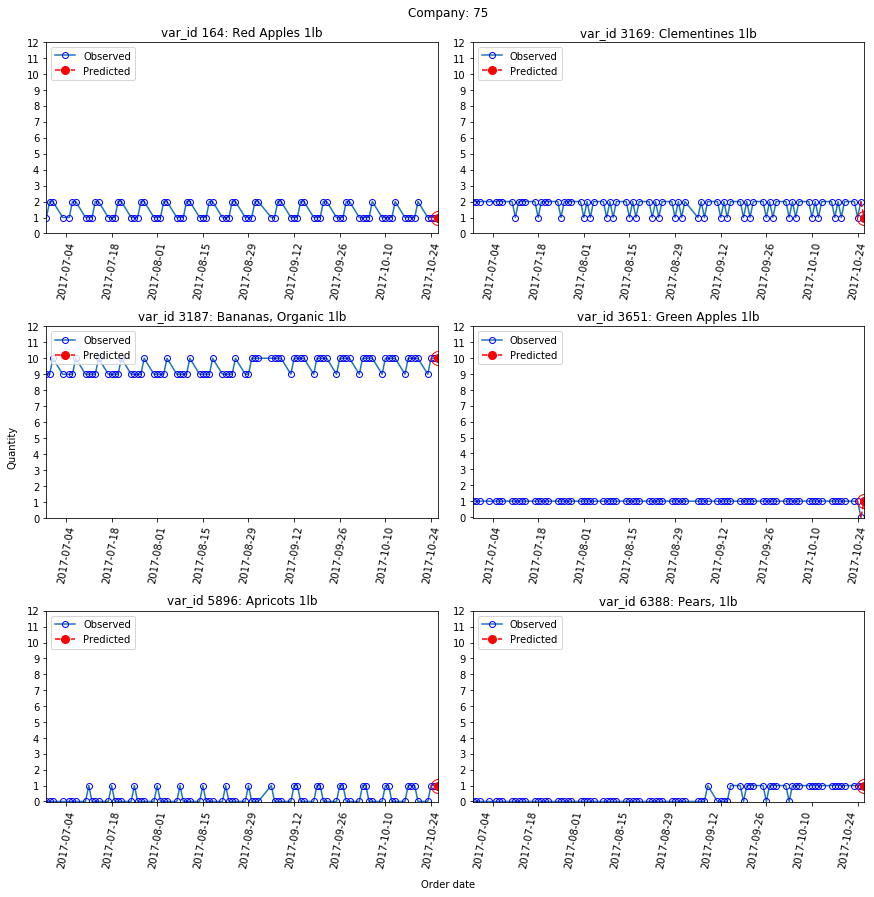

In [44]:

### plot all items for particular company
numItems = len(trim_basket)
numCol = 2
numRow = numItems // numCol + (numItems % numCol > 0)
reminder = numItems%numCol
height = 4 * numRow
#print (ymax)
#fig, axes = plt.subplots(nrows=numRow, ncols=numCol, sharex=True, sharey=True, figsize=(12, height))
fig, axes = plt.subplots(nrows=numRow, ncols=numCol, figsize=(12, height))
#axes_list = [item for sublist in axes for item in sublist] 

axes_list = axes.tolist()

counter = 0
for var_id in trim_basket:
    label =  "var_id "+str(var_id)+": "+description_dict[var_id]
    forecast_df = df_trim[var_id]   
    forecast_df["ds"] = pd.to_datetime(forecast_df["ds"])
    #predictionsize = forecast_df.shape[0]-df.shape[0]
    observedsize = forecast_df.shape[0] - 1
    ax = fig.axes[counter]
    getProphetPredictionGraph(var_id, label, ax, forecast_df, observedsize, xminaxis, xmaxaxis, ymin, ymax)
    counter = counter + 1

while counter < numItems:
    ax = (fig.axes[counter])
    ax.plot(0,0)
    counter = counter +1
    #ax.tick_params(labelbottom='off')  

fig.text(0.5, -0.01, 'Order date', ha='center')
fig.text(-0.01, 0.5, 'Quantity', va='center', rotation='vertical')
plt.suptitle("Company: "+str(company_id), y=1.01)

fig.tight_layout()
fig.show()
#print (xminaxis, xmaxaxis)

In [45]:
filteron = ["variant_id", "prod_description", "quantity"]
#print "Recommended order: "
filtered_all_order = all_order_df.filter(items = filteron)
new_order = filtered_all_order[filtered_all_order['variant_id'].isin(trim_basket)]
filtered_new_order = new_order.drop_duplicates(subset='variant_id', keep='first', inplace=False).reset_index(drop=True)
for var_id in trim_basket:
    filtered_new_order['quantity'][filtered_new_order.variant_id == var_id] = int(var_quantit[var_id])


recom_order_items = filtered_new_order["variant_id"]
recom_order_display = filtered_new_order.copy(deep = True)
recom_order_display.rename(columns = {"variant_id": "Product ID", "prod_description": "Product Description","quantity": "Quantity"}, inplace = True)

last_order = last_order_df.filter(items = filteron)
last_order.rename(columns = {"variant_id": "Product ID", "prod_description": "Product Description","quantity": "Quantity"}, inplace = True)

top_items = getTopFiveItemsNotInCurrentOrder(all_order_df, trim_basket)
top_items.rename(columns = {"variant_id": "Product ID", "prod_description": "Product Description","Avg_quantity": "Avg quantity"}, inplace = True)


list_items = recom_order_items.tolist()
boughtTogether = getCommonBoughtTogether(all_orders_over_time, list_items)


In [46]:
print (recom_order_display)

   Product ID Product Description  Quantity
0        3187         Bananas 1lb      10.0
1        6388          Pears, 1lb       1.0
2        3169     Clementines 1lb       1.0
3        3651    Green Apples 1lb       1.0
4         164      Red Apples 1lb       1.0
5        5896        Apricots 1lb       1.0


In [47]:
print (last_order)

   Product ID           Product Description  Quantity
0        3196  Organic Baby Carrots 2oz 6ct       1.0
1        3187                   Bananas 1lb      10.0
2        6388                    Pears, 1lb       3.0
3        3169               Clementines 1lb       3.0


In [48]:
print (top_items)

   Product ID           Product Description  Avg quantity
0        3196  Organic Baby Carrots 2oz 6ct             1
1        4546     Rudi's Organic Bread 22oz             1
2        4547     Rudi's Organic Bread 22oz             1
3        2701           English Muffin 12oz             1
4        5874        Organic Nectarines 1lb             2


In [55]:
filteron = ["antecedants", "current_list", "consequents", "recommend_list"]
boughtTogetherPairs = boughtTogether.filter(items = filteron)
colnamesList = ["variant_id1", "prod_description1", "variant_id2", "prod_description2"]
boughtTogetherPairs.columns =  colnamesList
boughtTogetherPairs.head()

,variant_id1,prod_description1,variant_id2,prod_description2
0,"(3187, 3651, 164)","Bananas, Organic 1lb,Green Apples 1lb,Red Appl...",(3169),Clementines 1lb
1,"(3169, 3187, 164)","Clementines 1lb,Bananas, Organic 1lb,Red Apple...",(3651),Green Apples 1lb
2,"(3169, 3651, 164)","Clementines 1lb,Green Apples 1lb,Red Apples 1lb",(3187),"Bananas, Organic 1lb"
3,"(3187, 3651, 164)","Bananas, Organic 1lb,Green Apples 1lb,Red Appl...",(3196),Organic Baby Carrots 2oz 6ct
4,"(3187, 3169, 3651)","Bananas, Organic 1lb,Clementines 1lb,Green App...",(164),Red Apples 1lb


In [1]:
displayboughtTogetherPairs = boughtTogetherPairs.copy(deep=True)
for index, row in displayboughtTogetherPairs.iterrows():
    prod_list1 = (list(row["variant_id1"]))
    newlist = [int(l) for l in prod_list1]
    str1 = "\n".join(str(x) for x in newlist)
    row["variant_id1"] = str1
    prod_list2 = (list(row["variant_id2"]))
    newlist = [int(l) for l in prod_list2]
    str1 = "\n".join(str(x) for x in newlist)
    row["variant_id2"] = str1
    str1 = row["prod_description1"].replace(",", "\n")
    row["prod_description1"] = str1
    str1 = row["prod_description2"].replace(",", "\n")
    row["prod_description2"] = str1

displayboughtTogetherPairs.head()

NameError: name 'boughtTogetherPairs' is not defined